![ups logo](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png/640px-Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png)

# Aprendizaje Automático

# Practica 03

# Deep Learning con Redes Neuronales Convolucionales (CNN). Transfer Learning y Métodos Ensemble. Clasificación de Imágenes con Dataset BraTS-2024

## Parte 2: Desarrollo de una Red Neuronal Convolucional (CNN)

### Autor: Diego Tapia

#### Instalación e importación de librerías

In [1]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from keras.layers import Flatten, Conv2D, Dropout, concatenate, MaxPooling2D, UpSampling2D
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from skimage import measure

import plotly.express as px

print("librerías importadas !")

librerías importadas !


### Preparación de las imágenes.

Se va a dividir nuestras imágenes en tres conjuntos: Entrenamiento, Validación y Prueba.  

Para recordar:

**Conjunto de Entrenamiento:** se utiliza para entrenar el modelo. Durante el entrenamiento, el modelo se expone a los datos de entrenamiento y ajusta sus parámetros para minimizar el error entre sus predicciones y la verdad del terreno (segmentaciones).

**Conjunto de Validación:** se utiliza para afinar los hiperparámetros de nuestro modelo, que se establecen antes del entrenamiento y determinan el comportamiento de nuestro modelo. El objetivo es comparar diferentes hiperparámetros y seleccionar la mejor configuración para nuestro modelo.

**Conjunto de Prueba:** se utiliza para evaluar el rendimiento de nuestro modelo después de haber sido entrenado, para ver qué tan bien se desempeña en datos no vistos.

**Nota.** Para minimizar el uso de recursos no se va usar el conjunto de validación propio de BraTS si no que se obtendrá del conjunto de training.


In [2]:
## Carga de datos en los diferentes conjuntos

data_path = '/content/drive/MyDrive/ISBI2024-BraTS-GoAT-TrainingData'
samples = os.listdir(data_path)
print("Numero de muestras:", len(samples))

Numero de muestras: 2251


In [3]:
# Division en Train, Validation y Test
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)


print(f"Numero de muestras en Training : {len(samples_train)}")
print(f"Numero de muestras en Validation : {len(samples_val)}")
print(f"Numero de muestras en Testing : {len(samples_test)}")


Numero de muestras en Training : 1530
Numero de muestras en Validation : 451
Numero de muestras en Testing : 270


In [4]:
listIDs = samples_train
VOLUME_START_AT = 60
VOLUME_SLICES = 75

IMG_SIZE = 128

In [5]:

class DataGenerator(keras.utils.Sequence):
    data_path = "/content/drive/MyDrive/ISBI2024-BraTS-GoAT-TrainingData"

    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # redimesiona a (128 x 128)
        self.batch_size = batch_size #  numero de imagenes para cargar a la vez
        self.list_IDs = list_IDs # ids de las muestras
        self.n_channels = n_channels # nuemro de modalidades ;T1C y  T2F (FLAIR)
        self.shuffle = shuffle # los datos seran mezclados
        self.on_epoch_end() # actualiza el indice en cada epoch


    def __len__(self):

        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):

        # Genera los indices del batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # busca los IDs (de cada sample)
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # cargalos datos
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):

        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):


        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))


        for c, i in enumerate(Batch_ids):

            # obtinene el path de cada modalidad de imagen

            sample_path = data_path+'/'+i+'/'+i

            t1ce_path = sample_path + '-t1c.nii.gz'
            flair_path = sample_path + '-t2f.nii.gz'
            seg_path = sample_path + '-seg.nii.gz'


            # extrae los datos de la imagenes
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()


            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        # segementaciones

        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        # Normalización

        return X/np.max(X), Y.numpy()

training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

print("datos generados train y testing !")

# Verificar una iteración del generador
X, y = next(iter(training_generator))
print("X shape:", X.shape)
print("y shape:", y.shape)


datos generados train y testing !
X shape: (75, 128, 128, 2)
y shape: (75, 128, 128, 4)


In [6]:
 # Modelo U-Net para BraTS 2019 por Naomi Fridman, https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)
print('Modelo CNN Unet definido')

Modelo CNN Unet definido


In [7]:
# Metricas de evaluacion
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

Para utilizar el modelo U-net propuesto debemos cambiar el tamaño de nuestras imágenes de 240 a 128  

In [8]:

IMG_SIZE = 128
from keras import Input
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

In [9]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

    keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{loss:.6f}.weights.h5',
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('training.log', separator=',', append=False)
]



### Entrenamiento del modelo CNN U-net

In [ ]:

history = model.fit(
        training_generator,
        epochs=8,
        steps_per_epoch=len(training_generator),
        callbacks=callbacks,
        validation_data=valid_generator,

    )

Epoch 1/8
1530/1530 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9859 - mean_io_u: 0.6381 - dice_coef: 0.2741 - precision: 0.9861 - sensitivity: 0.9836 - specificity: 0.9954
Epoch 1: val_loss improved from inf to 0.06300, saving model to model_.01-0.072856.weights.h5
1530/1530 [==============================] - 5721s 4s/step - loss: 0.0729 - accuracy: 0.9859 - mean_io_u: 0.6381 - dice_coef: 0.2741 - precision: 0.9861 - sensitivity: 0.9836 - specificity: 0.9954 - val_loss: 0.0630 - val_accuracy: 0.9857 - val_mean_io_u: 0.4645 - val_dice_coef: 0.2628 - val_precision: 0.9856 - val_sensitivity: 0.9856 - val_specificity: 0.9952 - lr: 0.0010
Epoch 2/8
1530/1530 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9868 - mean_io_u: 0.5699 - dice_coef: 0.3301 - precision: 0.9885 - sensitivity: 0.9849 - specificity: 0.9962
Epoch 2: val_loss improved from 0.06300 to 0.03768, saving model to model_.02-0.047015.weights.h5
1530/1530 [===================

In [16]:
# Cargar el modelo desde el archivo .h5

IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

model.load_weights('/content/drive/MyDrive/MachineLearning/BraTS_CNN_files/model_.06-0.023681.weights.h5')
print("modelo cargado")
model.summary()

modelo cargado
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 conv2d_69 (Conv2D)          (None, 128, 128, 32)         608       ['input_4[0][0]']             
                                                                                                  
 conv2d_70 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_69[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 64, 64, 32)           0         ['conv2d_70[0][0]']           
 ng2D)                                                                       

### Evaluación del modelo

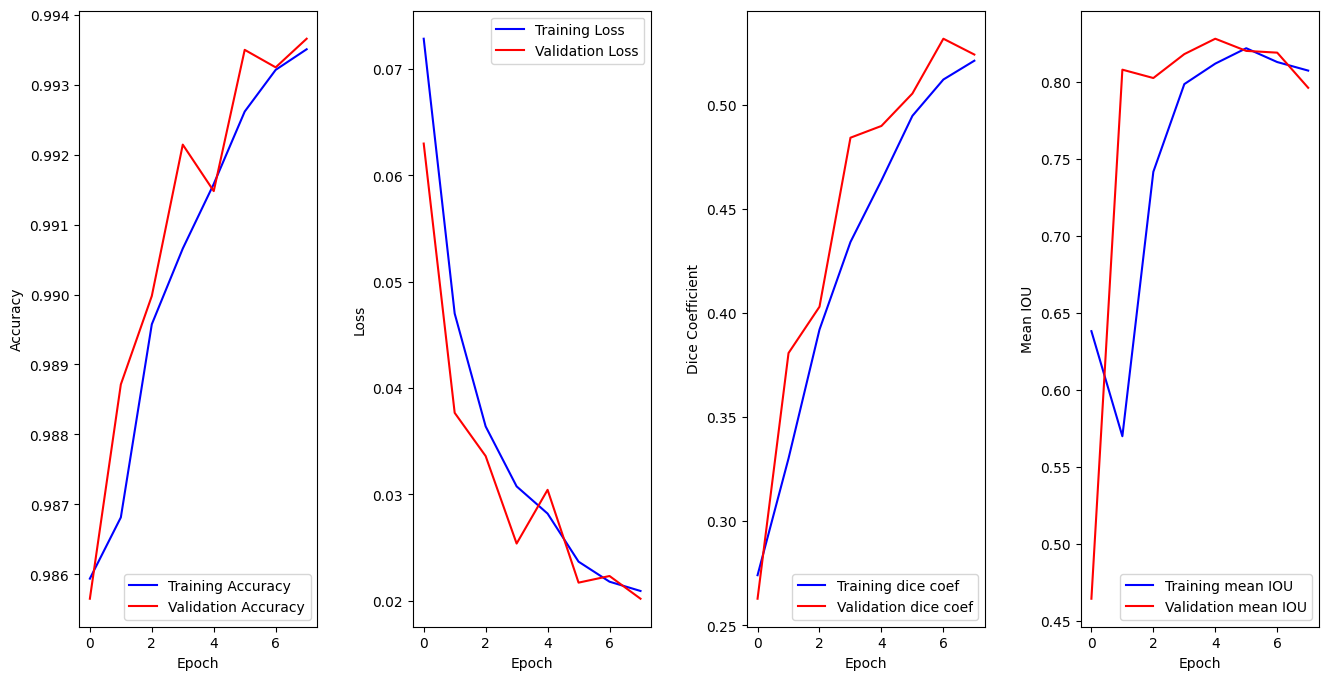

In [14]:
#Métricas de evaluación
history2 = pd.read_csv('/content/drive/MyDrive/MachineLearning/BraTS_CNN_files/training.log', sep=',', engine='python')

# Plot training and validation metrics
fig, axs = plt.subplots(1, 4, figsize=(16, 8))

axs[0].plot(history2['epoch'], history2['accuracy'], 'b', label='Training Accuracy')
axs[0].plot(history2['epoch'], history2['val_accuracy'], 'r', label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history2['epoch'], history2['loss'], 'b', label='Training Loss')
axs[1].plot(history2['epoch'], history2['val_loss'], 'r', label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].plot(history2['epoch'], history2['dice_coef'], 'b', label='Training dice coef')
axs[2].plot(history2['epoch'], history2['val_dice_coef'], 'r', label='Validation dice coef')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()

axs[3].plot(history2['epoch'], history2['mean_io_u'], 'b', label='Training mean IOU')
axs[3].plot(history2['epoch'], history2['val_mean_io_u'], 'r', label='Validation mean IOU')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Mean IOU')
axs[3].legend()


plt.subplots_adjust(wspace=0.4)

plt.show()

### Predicciones

In [17]:
def predict_segmentation(sample_path):

    t1ce_path = sample_path + '-t1c.nii.gz'
    flair_path = sample_path + '-t2f.nii.gz'

    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

In [20]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # se escoge un paciente aleatoriamente del conjunto de testing
    random_sample = random.choice(samples_list)
    data_path = "/content/drive/MyDrive/ISBI2024-BraTS-GoAT-TrainingData/"

    random_sample_path = data_path+random_sample+'/'+random_sample
    print(random_sample_path)

    predicted_seg = predict_segmentation(random_sample_path)


    seg_path = random_sample_path + '-seg.nii.gz'
    seg = nib.load(seg_path).get_fdata()


    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)


    all = predicted_seg[slice_to_plot,:,:,1:4]
    zero = predicted_seg[slice_to_plot,:,:,0]
    first = predicted_seg[slice_to_plot,:,:,1]
    second = predicted_seg[slice_to_plot,:,:,2]
    third = predicted_seg[slice_to_plot,:,:,3]


    print("Numero de muestra: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Segmentación original ')

    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Segmentación predecida (todas las mascaras) ')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Segmentación predecida  - mascara 0')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Segmentación predecida  - mascara 1')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Segmentación predecida  - mascara 2')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Segmentación predecida  - mascara 3')


    plt.subplots_adjust(wspace=0.8)

    plt.show()

/content/drive/MyDrive/ISBI2024-BraTS-GoAT-TrainingData/BraTS-GoAT-01829/BraTS-GoAT-01829
3/3 [==============================] - 0s 69ms/step
Numero de muestra:  BraTS-GoAT-01829


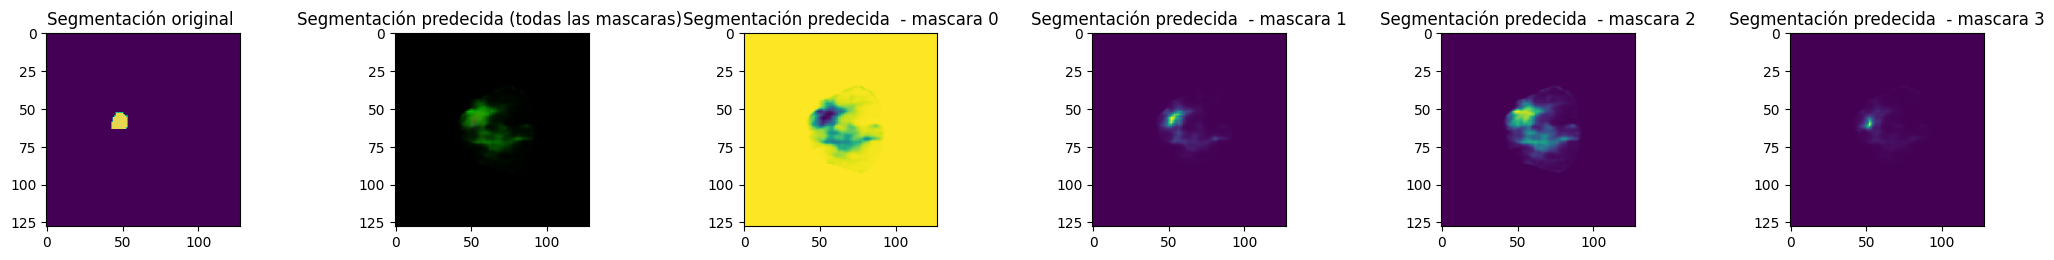

In [23]:
cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

show_predicted_segmentations(samples_test, 60, cmap, norm)

In [24]:
def show_post_processed_segmentations(sample, slice_to_plot, cmap, norm):


    sample_path = data_path+sample+ sample


    predicted_seg = predict_segmentation(sample_path)


    seg_path = sample_path + '-seg.nii.gz'
    seg = nib.load(seg_path).get_fdata()


    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # se quita el fondo
    seg[seg==0] = np.nan


    my_pred = np.argmax(predicted_seg, axis=3)
    my_pred = my_pred[slice_to_plot, :, :]


    my_pred = my_pred.astype(float)
    my_pred[my_pred == 0] = np.nan


    all = predicted_seg[slice_to_plot,:,:,1:4]


    print("Numero de muestra: ", sample)
    fig, axstest = plt.subplots(1, 3, figsize=(15, 10))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Segmentación original')

    axstest[1].imshow(all)
    axstest[1].set_title('Predición sin postprocesamiento (layers 1,2,3)')

    axstest[2].imshow(my_pred, cmap, norm)
    axstest[2].set_title('Predición con postprocesamiento (layers 1,2,3)')


    plt.subplots_adjust(wspace=0.8)

    plt.show()

3/3 [==============================] - 0s 70ms/step
Numero de muestra:  /BraTS-GoAT-01829


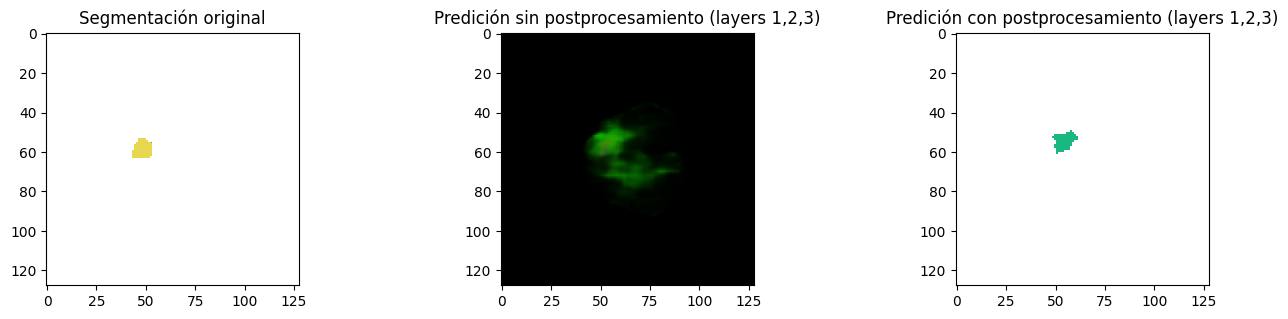

In [25]:
show_post_processed_segmentations(sample = "/BraTS-GoAT-01829", slice_to_plot=60, cmap=cmap, norm=norm)

### Evaluación del modelo con el conjunto de datos de Testing

In [26]:

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]


results_list = zip(results, descriptions)

# Display each metric with its description
print("\nEvaluación del modelo con el dataset de Testing :")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

270/270 [==============================] - 1972s 7s/step - loss: 0.0204 - accuracy: 0.9939 - mean_io_u_3: 0.8212 - dice_coef: 0.4944 - precision: 0.9945 - sensitivity: 0.9925 - specificity: 0.9981

Evaluación del modelo con el dataset de Testing :
Loss : 0.0204
Accuracy : 0.9939
MeanIOU : 0.8212
Dice coefficient : 0.4944
Precision : 0.9945
Sensitivity : 0.9925
Specificity : 0.9981



Evaluación del modelo UNET CNN con el dataset de Testing :

| Loss | Accuracy | MeanIOU | Dice coefficient | Precision | Sensitivity | Specificity |
|------|----------|---------|------------------|-----------|-------------|-------------|
| 0.0204 | 0.9939 | 0.8212 | 0.4944 | 0.9945 | 0.9925 | 0.9981 |
